In [ ]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
import math
from pathlib import Path
from matplotlib.gridspec import GridSpec
from scipy.spatial import Delaunay
from PIL import Image
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import networkx as nx
import ast
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import to_rgba
from matplotlib.patches import Rectangle
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
from functions import finding_defects as df
from functions import layers 
from functions import three_d as dimension

## pick which runs you want to view

In [3]:
data_type = "3.5"
#data_type = "1.5"
run_type = "Relaxed"
#run_type = "Random"

In [4]:
# load modeling data
if data_type == "3.5":
    all_blocks_model = dimension.make_modeling_df_NEW(data_dir= "data_30nm_3.5Ti", include_random=True)
else :
    all_blocks_model = dimension.make_modeling_df_NEW(data_dir= "data_30nm_1.5Ti", include_random=True)

grouped = all_blocks_model.groupby(['size', 'vTi', 'vC', 'Tx', 'run_type'])
for size, vTi, vC, Tx, run_type in grouped.groups.keys():
    print(f"size={size}nm, vTi={vTi}, vC={vC}, Tx={Tx}, run_type={run_type}")

size=30nm, vTi=0.035, vC=0.0, Tx=0.0, run_type=Random
size=30nm, vTi=0.035, vC=0.0, Tx=0.0, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.0, Tx=0.5, run_type=Random
size=30nm, vTi=0.035, vC=0.0, Tx=0.5, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.0, Tx=0.8, run_type=Random
size=30nm, vTi=0.035, vC=0.0, Tx=0.8, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.01, Tx=0.0, run_type=Random
size=30nm, vTi=0.035, vC=0.01, Tx=0.0, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.01, Tx=0.5, run_type=Random
size=30nm, vTi=0.035, vC=0.01, Tx=0.5, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.01, Tx=0.8, run_type=Random
size=30nm, vTi=0.035, vC=0.01, Tx=0.8, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.05, Tx=0.0, run_type=Random
size=30nm, vTi=0.035, vC=0.05, Tx=0.0, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.05, Tx=0.5, run_type=Random
size=30nm, vTi=0.035, vC=0.05, Tx=0.5, run_type=Relaxed
size=30nm, vTi=0.035, vC=0.05, Tx=0.8, run_type=Random
size=30nm, vTi=0.035, vC=0.05, Tx=0.8, run_type=Relaxed
size=30

In [5]:
all_blocks_model

,x,y,z,atype,label,group,category,cluster_id,size,vTi,vC,Tx,run_type
0,0.475881,0.502734,2.03646,7,ST,-1,atom,-1,30,0.035,0.00,0.0,Relaxed
1,1.962990,3.078460,2.03646,7,ST,-1,atom,-1,30,0.035,0.00,0.0,Relaxed
2,1.961590,1.355190,3.16566,1,atom,2,atom,-1,30,0.035,0.00,0.0,Relaxed
3,0.472432,3.935880,3.16177,1,atom,2,atom,-1,30,0.035,0.00,0.0,Relaxed
4,0.482384,2.225690,4.35809,2,C,-1,atom,-1,30,0.035,0.00,0.0,Relaxed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948795,295.364000,297.996000,6.79962,2,C,-1,atom,-1,30,0.035,0.01,0.5,Random
1948796,295.339000,296.294000,8.00663,1,atom,3,atom,-1,30,0.035,0.01,0.5,Random
1948797,296.867000,298.908000,8.03950,1,atom,3,atom,-1,30,0.035,0.01,0.5,Random
1948798,295.336000,294.553000,8.97177,7,ST,-1,atom,-1,30,0.035,0.01,0.5,Random


In [6]:
# load experimental data
percentages = ["5", "9_1", "12_5"]
BASE_PM   = 185
loaded_data = {}

for perc in percentages:
    fn = f"stats/{perc}_percent_stats_20250623.pkl"
    with open(fn, "rb") as f:
        loaded_data[perc] = pickle.load(f)   

def tree(obj, indent=0, max_list_items=1):
    pad = " " * indent
    if isinstance(obj, dict):
        for k, v in obj.items():
            print(f"{pad}{k!r}: {type(v).__name__}")
            tree(v, indent + 4, max_list_items)
    elif isinstance(obj, list) and obj:
        for i, v in enumerate(obj[:max_list_items]):
            print(f"{pad}[{i}]: {type(v).__name__}")
            tree(v, indent + 4, max_list_items)

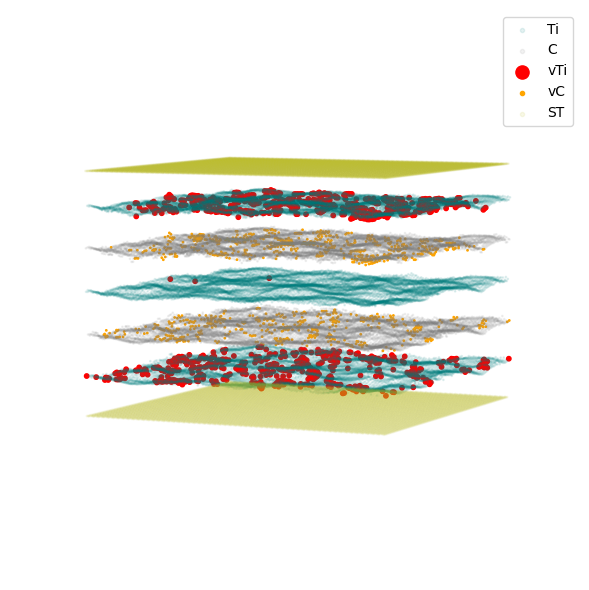

In [7]:
if data_type == "3.5":
    run_df = all_blocks_model.query(f"size == 30 and vTi == 0.035 and vC == .05 and Tx == 0 and run_type == '{run_type}'")
else :
    run_df = all_blocks_model.query(f"size == 30 and vTi == 0.015 and vC == .05 and Tx == 0 and run_type == '{run_type}'")



sub = run_df

label_to_atype = {'atom': 1, 'defect': 5}
atype = sub['atype'].values
pos   = sub[['x', 'y', 'z']].values

fig = plt.figure(figsize=(7, 6))
ax  = fig.add_subplot(111, projection='3d')

pos_crop = pos
atype_crop = atype

color_map = {
    1: 'teal',    # Ti
    2: 'gray',
    3: 'lightgray',        # C
    4: 'green',       # Maybe O or H
    5: 'red',         # Vacancy marker
    6: 'cyan',       
    7: 'tab:olive',      # Other
}


for t in sorted(set(atype_crop)):
    mask = atype_crop == t
    if t == 1:  # Ti or defect
        ax.scatter(pos_crop[mask, 0], pos_crop[mask, 1], pos_crop[mask, 2],
                   s=1, label=f'Ti', c=color_map.get(t, 'black'), alpha=.1)
    elif t == 2:  # C
        ax.scatter(pos_crop[mask, 0], pos_crop[mask, 1], pos_crop[mask, 2],
                   s=1, label=f'C', c=color_map.get(t, 'black'), alpha=.1)
    elif t == 5:
        ax.scatter(pos_crop[mask, 0], pos_crop[mask, 1], pos_crop[mask, 2],
                   s=10, label=f'vTi', c='red', alpha=1)
    elif t == 6:
        ax.scatter(pos_crop[mask, 0], pos_crop[mask, 1], pos_crop[mask, 2],
                   s=1, label=f'vC', c='orange', alpha=1)
    elif t == 3 :  
        ax.scatter(pos_crop[mask, 0], pos_crop[mask, 1], pos_crop[mask, 2],
                   s=1,  c=color_map.get(t, 'black'), alpha=.1, label = "ST")

    elif t == 4 :  
        ax.scatter(pos_crop[mask, 0], pos_crop[mask, 1], pos_crop[mask, 2],
                   s=1,  c=color_map.get(t, 'black'), alpha=.1, label = "ST")

    elif t == 7 :  
        ax.scatter(pos_crop[mask, 0], pos_crop[mask, 1], pos_crop[mask, 2],
                   s=1,  c=color_map.get(t, 'black'), alpha=.1, label = "ST")
    else:
        print("there's something else?")



#ax.set_box_aspect([1, 1, 0.4])
ax.view_init(elev=5, azim=25)
ax.axis('off')
ax.legend(markerscale=3, loc='upper right')
plt.tight_layout()
plt.show()


In [8]:
xmin, xmax = 130, 170
ymin, ymax = 130, 170

(129.33495, 171.92804999999998, 128.12095, 171.63805)

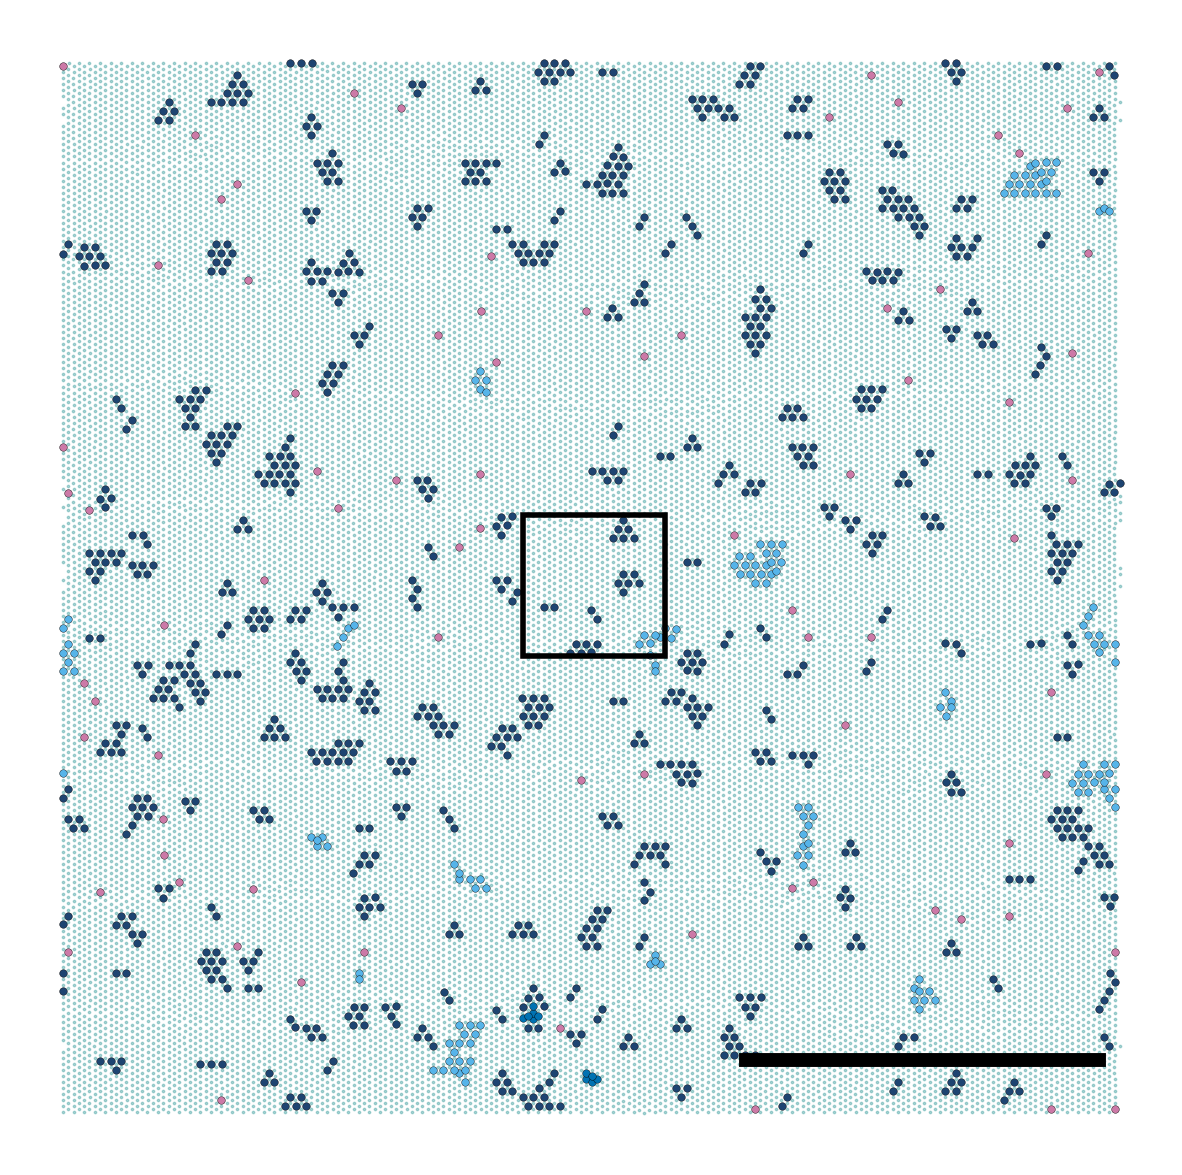

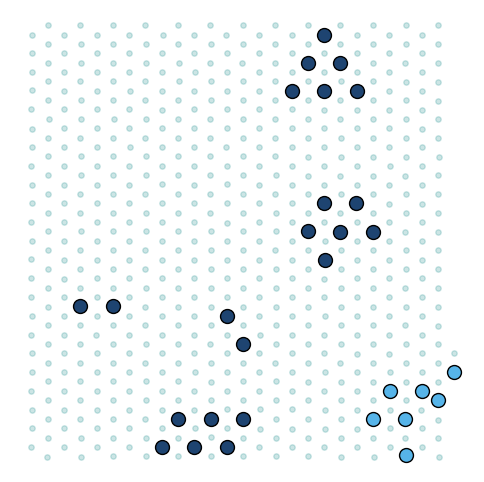

In [12]:
cat_palette = {
    "isolated vacancy": "#CC79A7",   
    "complex"         : "#56B4E9",   
    "nanopore"        : "#0072B2",   
    "surface_cluster" : "#1E4471",   
    "middle_cluster"  : "#009E73"
}


# ─── full plot ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 15))

for cat, color in cat_palette.items():
    mask = run_df['category'] == cat
    ax.scatter(run_df.loc[mask, 'x'], run_df.loc[mask, 'y'],
               c=color, s=30, label=cat.replace("_", " "),
               edgecolor='black', linewidth=0.3)

atom_mask = run_df['label'] == 'atom'
ax.scatter(run_df.loc[atom_mask, 'x'], run_df.loc[atom_mask, 'y'],
           c='teal', s=3, alpha=0.3, label='atom')

ax.add_patch(Rectangle(
    (xmin, ymin), xmax - xmin, ymax - ymin,
    linewidth=4, edgecolor='black', facecolor='none'
))
# scale bar (1/3 of full image x-range), placed bottom-right
x_allmin, x_allmax = run_df['x'].min(), run_df['x'].max()
y_allmin, y_allmax = run_df['y'].min(), run_df['y'].max()

bar_len = (x_allmax - x_allmin) / 3
bar_x1 = x_allmax - bar_len - 0.02 * (x_allmax - x_allmin)
bar_x2 = x_allmax - 0.02 * (x_allmax - x_allmin)
bar_y  = y_allmin + 0.05 * (y_allmax - y_allmin)


ax.plot([bar_x1, bar_x2], [bar_y, bar_y],
        color='black', lw=10)
ax.axis('off')

# ─── cropped plot ─────────────────────────────────────────────
crop_mask = (
    (run_df['x'] >= xmin) & (run_df['x'] <= xmax) &
    (run_df['y'] >= ymin) & (run_df['y'] <= ymax)
)

fig_crop = plt.figure(figsize=(6, 6))
for cat, color in cat_palette.items():
    sub = run_df[crop_mask & (run_df['category'] == cat)]
    plt.scatter(sub['x'], sub['y'], c=color, s=100,
                edgecolor='black', linewidth=1)

sub_atoms = run_df[crop_mask & (run_df['label'] == 'atom')]
plt.scatter(sub_atoms['x'], sub_atoms['y'], c='teal', s=15, alpha=0.2)

plt.axis('equal')
plt.axis('off')




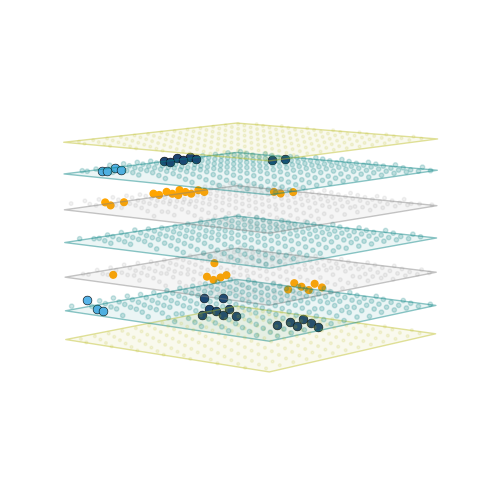

In [13]:
# palettes
color_map = {1:'teal', 2:'gray', 3:'lightgray', 4:'green', 5:'red', 6:'cyan', 7:'tab:olive'}
cat_palette = {
    "isolated vacancy": "#CC79A7",
    "complex"         : "#56B4E9",
    "nanopore"        : "#0072B2",
    "surface_cluster" : "#1E4471",
    "middle_cluster"  : "#009E73"
}

# data
pos   = run_df[['x', 'y', 'z']].values
atype = run_df['atype'].values

zmin, zmax = 0, 10
crop = (
    (pos[:, 0] >= xmin) & (pos[:, 0] <= xmax) &
    (pos[:, 1] >= ymin) & (pos[:, 1] <= ymax) &
    (pos[:, 2] >= zmin) & (pos[:, 2] <= zmax)
)
pos_crop   = pos[crop].copy()
atype_crop = atype[crop]

# detect layer centers on original z
tol = 0.5
z_vals = np.sort(pos_crop[:, 2])
layer_centers = []
for z in z_vals:
    if not layer_centers or abs(z - layer_centers[-1]) > tol:
        layer_centers.append(z)
if len(layer_centers) > 7:
    mid = np.median(layer_centers)
    layer_centers = [zc for _, zc in sorted((abs(zc - mid), zc) for zc in layer_centers)[:7]]

# stretch z for both points and planes
scale_z = 10.0
pos_crop[:, 2] *= scale_z
layer_centers  = [zc * scale_z for zc in layer_centers]
tol *= scale_z  # keep 'near' thickness proportional after stretching

# ranges for planes
x_range = (pos_crop[:, 0].min(), pos_crop[:, 0].max())
y_range = (pos_crop[:, 1].min(), pos_crop[:, 1].max())
xx, yy = np.meshgrid(np.linspace(*x_range, 2), np.linspace(*y_range, 2))

# plot
fig = plt.figure(figsize=(10, 5))
ax  = fig.add_subplot(111, projection='3d')

# transparent planes (one per layer)
for zc in sorted(layer_centers):
    near = np.abs(pos_crop[:, 2] - zc) < tol
    if not near.any():
        continue
    majority_type = np.bincount(atype_crop[near].astype(int)).argmax()
    base_color = color_map.get(majority_type, 'gray')
    fc = to_rgba(base_color, 0.08)
    ec = to_rgba(base_color, 0.45)
    zz = np.full_like(xx, zc, dtype=float)
    ax.plot_surface(xx, yy, zz,
                    facecolors=np.tile(fc, xx.shape + (1,)),
                    edgecolor=ec, linewidth=1, antialiased=True, shade=False)

# points (stretched z already)
for t in sorted(set(atype_crop)):
    mask_t = atype_crop == t
    if t == 1:
        ax.scatter(pos_crop[mask_t, 0], pos_crop[mask_t, 1], pos_crop[mask_t, 2],
                   s=10, c='teal', alpha=0.2)
    elif t == 2:
        ax.scatter(pos_crop[mask_t, 0], pos_crop[mask_t, 1], pos_crop[mask_t, 2],
                   s=7, c='gray', alpha=0.1)
    elif t == 5:
        vti_pos = pos_crop[mask_t]
        for cat, color in cat_palette.items():
            sub = run_df[
                (run_df['category'] == cat) &
                (run_df['label'] == 'defect') &
                (run_df['x'] >= xmin) & (run_df['x'] <= xmax) &
                (run_df['y'] >= ymin) & (run_df['y'] <= ymax) &
                (run_df['z'] >= zmin) & (run_df['z'] <= zmax)
            ]
            for _, row in sub.iterrows():
                xy = np.array([row['x'], row['y']])
                dists = np.linalg.norm(vti_pos[:, :2] - xy, axis=1)
                if dists.size == 0:
                    continue
                idx = np.argmin(dists)
                if dists[idx] < 1.0:
                    x, y, z = vti_pos[idx]
                    ax.scatter(x, y, z, s=40, c=color, edgecolor='black', linewidth=0.4)
    elif t == 6:
        ax.scatter(pos_crop[mask_t, 0], pos_crop[mask_t, 1], pos_crop[mask_t, 2],
                   s=23, c='orange', alpha=1)
    elif t == 7:
        ax.scatter(pos_crop[mask_t, 0], pos_crop[mask_t, 1], pos_crop[mask_t, 2],
                   s=4, c='tab:olive', alpha=0.12)

ax.view_init(elev=8, azim=40)
ax.axis('off')
plt.tight_layout()
plt.show()



In [14]:
experimental = pd.read_csv("../2_three_dimensional/all_filtered_data.csv")

if data_type == "3.5":
    experimental = experimental[experimental['percent'] == "12_5"]
else: 
    experimental = experimental[experimental['percent'] != "12_5"]

round(100 * experimental['category'].value_counts(normalize=True), 2)

category
atom                96.51
isolated vacancy     1.43
surface_cluster      0.90
complex              0.70
nanopore             0.29
sandwich             0.12
pit                  0.05
middle_cluster       0.01
Name: proportion, dtype: float64

In [15]:
100 * run_df[run_df["label"] == "defect"]['category'].value_counts(normalize=True).round(4)

category
surface_cluster     79.56
complex             13.05
isolated vacancy     6.49
nanopore             0.90
Name: proportion, dtype: float64

In [16]:
all_blocks_model_relaxed = all_blocks_model.query("run_type == 'Relaxed'")
all_blocks_model_random = all_blocks_model.query("run_type == 'Random'")

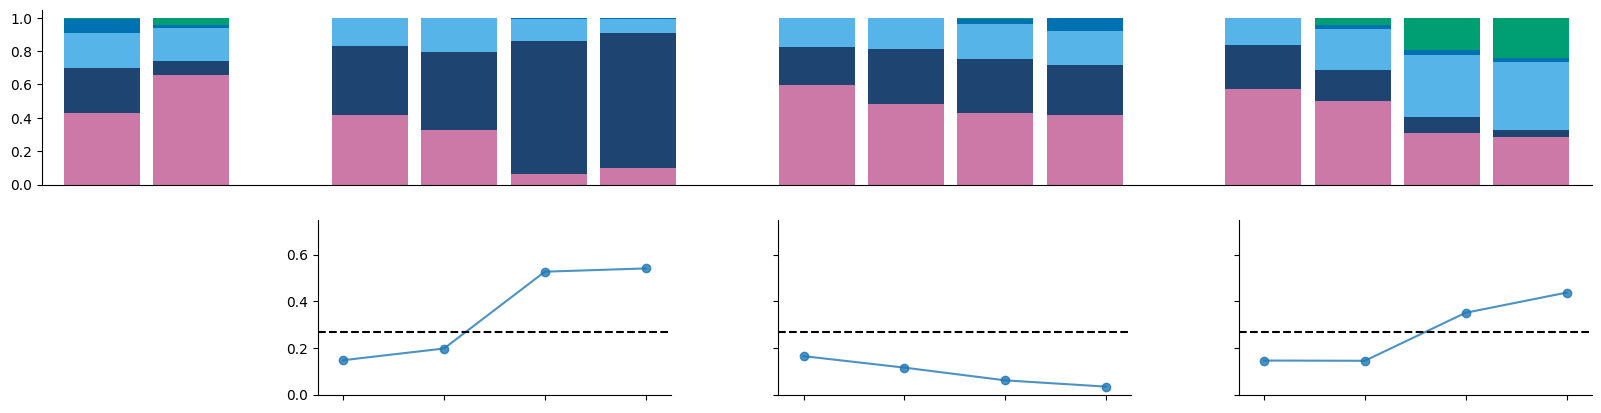

In [22]:
cats = ['isolated vacancy', 'surface_cluster', 'complex', 'nanopore', 'middle_cluster']

props, tx_groups, rand_scores, metrics_df_raw = dimension.build_props(
    all_blocks_model_relaxed=all_blocks_model_relaxed,
    all_blocks_model_random=all_blocks_model_random,
    experimental=experimental,
    cats=cats,
)

fig, axes = dimension.plot_three_panel(
    props=props,
    cats=cats,
    cat_palette=cat_palette,
    tx_groups=tx_groups,
    rand_scores=rand_scores,
    ylim=(0, 0.75),
    figsize=(20, 5),
)



In [ ]:
metrics_sorted = metrics_df_raw.sort_values("TVD").reset_index(drop=True)

print("\n=== Ranked by TVD (Closest to Experiment First) ===")
display(metrics_sorted.head(10))  



=== Ranked by TVD (Closest to Experiment First) ===


,Label,L1,TVD
0,Experiment,0.000000,0.000000
1,"Tx=0.5, 30nm, vTi=0.035, vC=0.100",0.067450,0.033725
2,"Tx=0.5, 30nm, vTi=0.035, vC=0.050",0.121300,0.060650
3,"Tx=0.5, 30nm, vTi=0.035, vC=0.010",0.230396,0.115198
4,"Tx=0.8, 30nm, vTi=0.035, vC=0.010",0.288962,0.144481
5,"Tx=0.8, 30nm, vTi=0.035, vC=0.000",0.291025,0.145512
6,"Tx=0.0, 30nm, vTi=0.035, vC=0.000",0.294051,0.147025
7,"Tx=0.5, 30nm, vTi=0.035, vC=0.000",0.328791,0.164396
8,"Tx=0.0, 30nm, vTi=0.035, vC=0.010",0.394215,0.197107
9,Random,0.535351,0.267676
